# Latent Space Approaches to Social Network Analysis

## Introduction

In the study of historical social networks, the relationships between influential families provide valuable insights into power dynamics, alliances, and social structures. One such case is the analysis conducted by Padgett and Ansell (1993), which examines marriage and business ties among 16 historically prominent Florentine families during the 15th century. Their work is based on historical accounts, particularly the research of Kent (1978), which documents the socio-political landscape of Renaissance Florence.

This notebook focuses specifically on the marriage relations between these families. In this dataset, a tie exists between two families if at least one marriage occurred between them. The relationship is undirected, as the records do not specify the respective families of the husband and wife. Notably, one of the 16 families had no marriage ties to others and was consequently excluded from the analysis. Including this family would result in an infinite distance in a maximum likelihood estimation and a large but finite distance in a Bayesian framework. By modeling these marriage relations using network analysis techniques, we can explore the structural properties of the Florentine elite and their strategic matrimonial alliances. This analysis provides a deeper understanding of the role of marriage in shaping political and economic power during the Renaissance. This work is inspired and replicated according the article of Hoff 2002 (consult [1]).

We are going to use the following libraries:

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

## Florentine Families Network

The graph of the Florentine families is presented in the following plot.

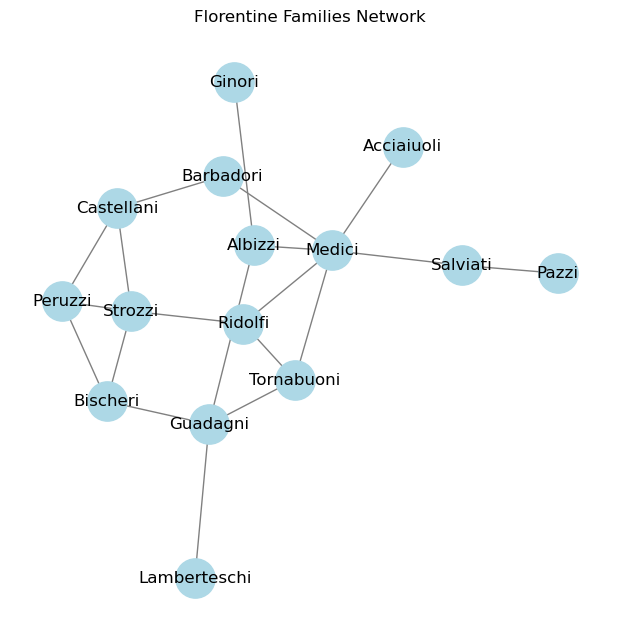

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()


It is important to reindex with integer number the previous network in order to deal with nodes and edges easily.

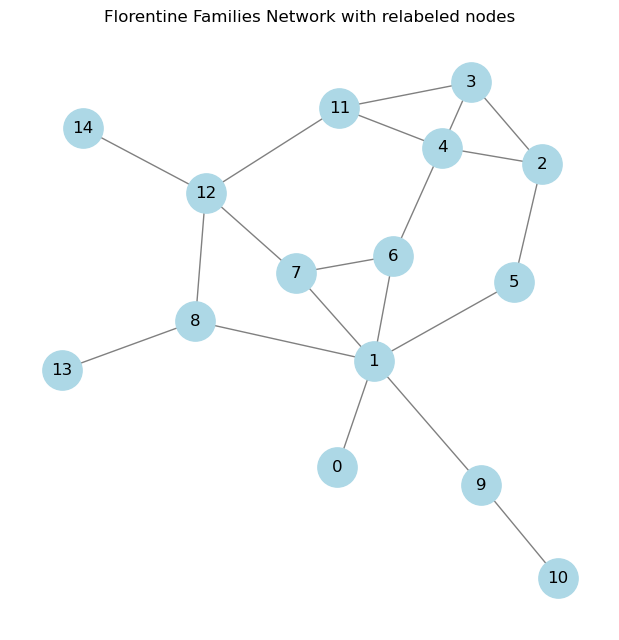

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [3]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

The sociomatrix $Y$ or adjacency matrix is calculated in the following code.

In [4]:
nx.to_numpy_array(G, dtype=int)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

<Axes: >

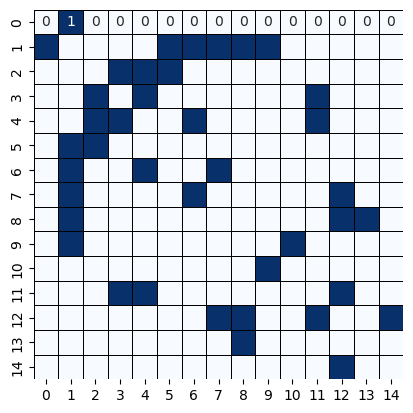

In [5]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=True, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')

## Latent Space

To start the latent space model, the number of nodes $n$ in the graph is calculated and the latent variables are randomly initialized with sampling from a normal standard distribution a matrix of size $n\times 2$ since we are representing our network in a $2$-dimensional space.

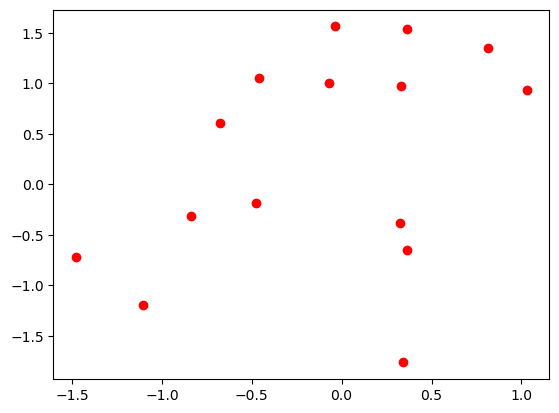

In [6]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

## Likelihood

In order to calculate the probability to have a tie between two nodes given the latent variables and its properties, the following model is proposed:


$$\eta_{ij} := logit(\mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a)) = a (1-d_{ij}),$$

equivalently,

$$\mu_{ij} := \mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a) = expit(a (1-d_{ij})) = \frac{1}{1+\exp{(-a(1-d_{ij}))}},$$

where $d_{ij}$ measures the distance between the two latent variables in the next way,

$$d_{ij} = \frac{1}{2}\|z_i-z_j\|^2.$$

Since $y_{ij}\in\{0,1\}$ and we suppose that the conection bewteen edges are independente, then the likelihood is given by the expression

$$L(\eta) = \mathbb{P}(Y\ |\ \eta) = \prod_{i\not=j} \mu_{ij}^{y_{ij}}(1-\mu_{ij})^{1-y_{ij}},$$


and the log-likelihood

$$\ell(\eta) = \log(\mathbb{P}(Y\ |\ \eta)) = \sum_{i\not=j} \eta_{ij}y_{ij} - \log(1+e^{\eta_{ij}}),$$

with its respective derivatives,


$$\frac{\partial}{\partial z_{k}} \ell(\eta) = \sum_{i\not=k} a (z_k-z_i)\left(expit(\eta_{ki})- y_{ki}\right),$$

$$\frac{\partial}{\partial a} \ell(\eta) =  \sum_{i\not=j} -(1-d_{ij})\left(expit(\eta_{ki})- y_{ki}\right).$$

In [7]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            dist = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
            eta = a - dist
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                eta = a - dist
                grad_Z[i,:] +=  (Z[i] - Z[j]) * (expit(eta) - y)
                grad_a += (-1) * (1) * (expit(eta) - y) 
    return grad_Z, grad_a

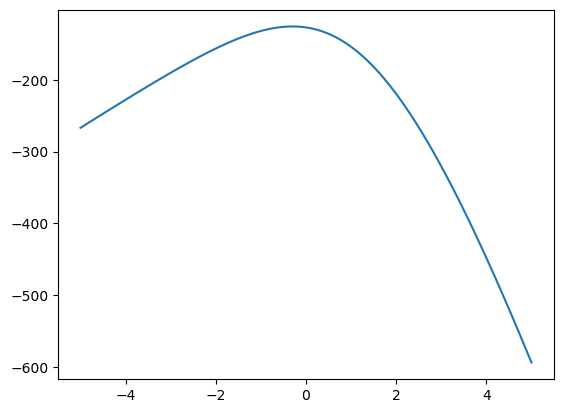

In [8]:
plt.plot(np.linspace(-5,5,100),[loglikelihood(Z,t) for t in np.linspace(-5,5,100)])
plt.show()

-127.92878340225556
-126.09003250346419


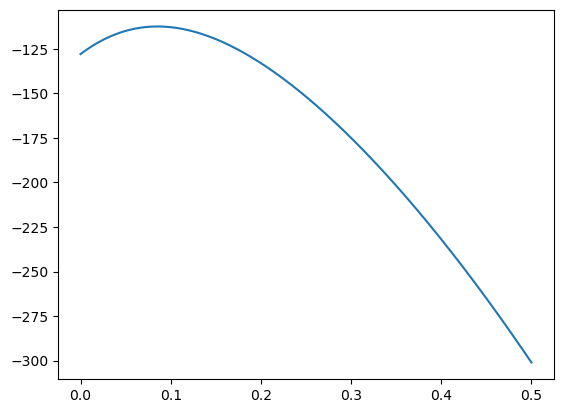

In [9]:
grad_Z,  grad_a = grad_loglikelihood(Z,0.1)
lr = 0.005
print(loglikelihood(Z,0.1))
print(loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.5,1000),[loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,0.5,1000)])
plt.show()

### Searching MLE

For searching the maximum likelihood estimation, we search the maximum of the loglikelihood function through gradient descent with line search.

In [10]:
def SearchingMLE(Z_init, a_init, max_iter=1000, tol=1e-4, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(Z0 + alpha * grad_Z,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-9:
                alpha = 0.0
                break
        
        # Update step
        Z0 = Z0 + alpha * grad_Z  
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)

        if alpha * np.linalg.norm(grad_Z) < tol and alpha * np.abs(grad_a) < tol:
            break
    
    return  Z0, a0, historyZ, historya

Loglikelihood: -0.09279048826118796


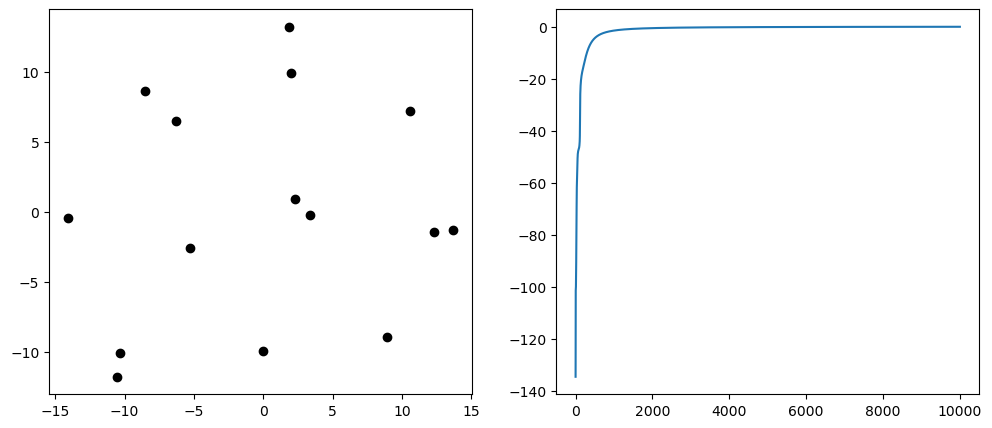

In [11]:
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(0.1*np.random.randn(n, 2),np.random.randn(),10000)
Z_ML = Z_ML - np.mean(Z_ML, axis=0)

print("Loglikelihood:", loglikelihood(Z_ML,a_ML))

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].plot(Z_ML[:,0],Z_ML[:,1], 'ko')
ax[1].plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

### Sociomatrix

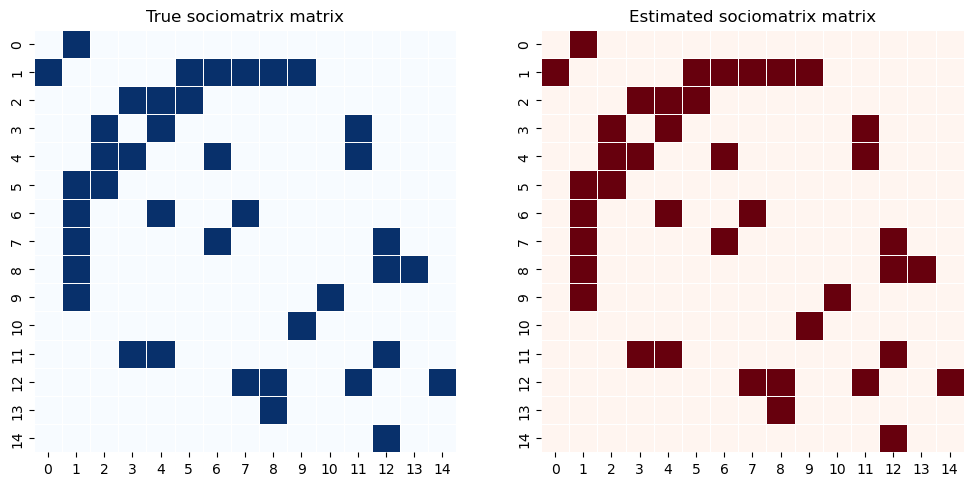

In [12]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_ML[i,j] = expit(a_ML - 0.5 * np.linalg.norm(Z_ML[i] - Z_ML[j])**2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

## Prior distribution

In [13]:
def logpriori(Z,a,var=10):
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + 0.5 * np.sum(Z**2)/var + 0.5 * a**2 / var)

In [14]:
def grad_logpriori(Z,a,var=10):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = (-1) * Z[i,:] / var
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

-34.32724065386913
-33.12369727522713


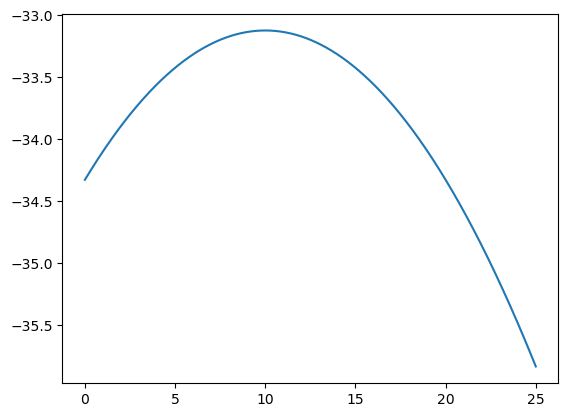

In [15]:
grad_Z,  grad_a = grad_logpriori(Z,0.1)
lr = 10
print(logpriori(Z,0.1))
print(logpriori(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,25.0,1000),[logpriori(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,25.0,1000)])
plt.show()

## Potential energy

In [16]:
def U(Z,a,var=1):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=1):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a



def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                eta = a - dist
                grad_Z[i,:] +=  (Z[i] - Z[j]) * (expit(eta) - y)
                grad_a += (-1) * (1) * (expit(eta) - y) 
    return grad_Z, grad_a


def grad_U_i(Z,a,i,var=1):
    grad_Z_i = np.zeros(Z.shape[1])
    grad_a = 0.0
    for j in G.nodes():
        if j != i:
            y = 1.0 if j in G.neighbors(i) else 0.0
            dist = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
            eta = a - dist
            grad_Z_i +=  (Z[i] - Z[j]) * (expit(eta) - y)
            grad_a += (-1) * (1) * (expit(eta) - y) 
    grad_Z_i += (-1) * Z[i,:] / var
    return -grad_Z_i


def grad_U_a(Z,a,var=1):
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = 0.5 * np.linalg.norm(Z[i] - Z[j])**2
                eta = a - dist
                grad_a += (-1) * (1) * (expit(eta) - y) 
    grad_a += (-1) * a / var 
    return -grad_a



In [17]:
np.zeros(Z.shape[1])

array([0., 0.])

154.66723371995033
152.30290718184733


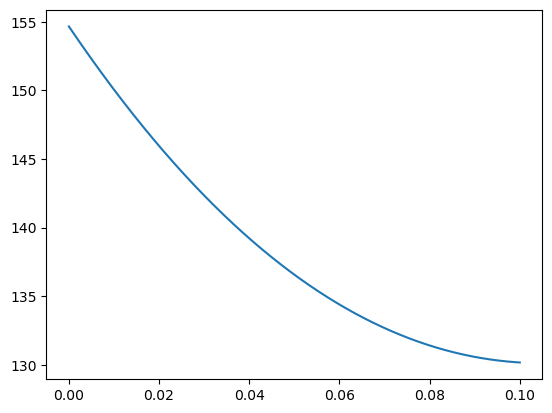

In [18]:
grad_Z,  grad_a = grad_U(Z,0.1)
lr = 0.005
print(U(Z,0.1))
print(U(Z - lr*grad_Z,0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[U(Z -lr*grad_Z,0.1-lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [19]:
def compute_Z_star(Z, Z0):
    """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
    A = Z @ Z0.T @ Z0 @ Z.T  # Compute A = Z Z0^T Z0 Z^T
    
    # Compute A^(-1/2) using SVD
    U, S, _ = np.linalg.svd(A)
    S_inv_sqrt = np.diag(1.0 / np.sqrt(S))
    A_inv_sqrt = U @ S_inv_sqrt @ U.T
    Z_star =  Z0 @ Z.T @ A_inv_sqrt @ Z
    # Compute Z*
    return Z_star - np.mean(Z_star, axis=0)

In [20]:
def hmc(Z_init, a_init, num_samples, epsilon_init=0.05, std_dev=1.0, percentage_warmup=0.2):
    """
    Hamiltonian Monte Carlo (HMC) sampling algorithm.
    Parameters:
    - Z_init: Initial value for Z.
    - a_init: Initial value for a.
    - num_samples: Number of samples to generate.
    - epsilon_init: Initial step size for the leapfrog integrator.
    - std_dev: Standard deviation for the momentum variable.
    - percentage_warmup: Percentage of samples to use for warmup.
    Returns:
    - samples_Z: Generated samples for Z.
    - samples_a: Generated samples for a.
    - Hamiltonian_p: Hamiltonian values for each sample.
    - LogL: Log-likelihood values for each sample.
    - acep_rate_history: Acceptance rate history.
    """

    
    number_of_parameters = Z_init.shape[0] + 1
    warmup = int(num_samples * percentage_warmup)
    number_of_iterations = num_samples + warmup
    print(f"Number of samples: {num_samples}")
    print(f"Number of parameters: {number_of_parameters}")
    print(f"Number of iterations: {number_of_iterations}")
    print(f"Number of warmup iterations: {warmup}")
   

    samples_Z = [Z_init]
    samples_a = [a_init]
    Hamiltonian_p = [U(Z_init,a_init)]
    LogL = [loglikelihood(Z_init,a_init)]

    acep_rate_history = np.zeros(number_of_iterations)
    

    Z = Z_init.copy()
    a = a_init.copy()

    # Parámetros adaptativos
    epsilon = epsilon_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    
    for iter in tqdm(range(number_of_iterations)):

        # Tunning algorithm parameters
        adapting = iter < warmup
        if adapting and iter > 0:
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.80:
                epsilon = np.max(np.array([0.01,0.99*epsilon])) 
                std_dev = np.max(np.array([0.05,0.99*std_dev]))
            elif current_accept_rate > 0.60:
                epsilon = np.min(np.array([0.2,1.01*epsilon]))
                std_dev = np.min(np.array([1.75,1.01*std_dev]))
            L = max(1, int(round(1/epsilon))) 
        elif iter == warmup:
            print(f"Final parameters: epsilon={epsilon:.4f}, L={L}, std_dev={std_dev:.4f}")



        _,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        ### HMC algorithm for Z

        for i in range(Z.shape[0]):
            Z_current = Z.copy()
            Z_i = Z[i].copy()
            grad_Z_i = grad_U_i(Z_current, samples_a[-1], i)


            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            current_p = p_i.copy()

            # Leapfrog integration
            p_i -= epsilon * grad_Z_i / 2
            for _ in range(L):
                Z_i += epsilon * p_i / std_dev**2
                Z_temp = Z_current.copy()
                Z_temp[i] = Z_i  
                grad_Z_i = grad_U_i(Z_temp, samples_a[-1], i)
                p_i -= epsilon * grad_Z_i
            p_i -= epsilon * grad_Z_i / 2
  
            # Hamiltonian
            Z_proposed = Z_current.copy()
            Z_proposed[i] = Z_i
            current_U = U(Z_current, samples_a[-1])
            proposed_U = U(Z_proposed, samples_a[-1])
            current_K = 0.5 * np.sum(current_p**2) / std_dev**2
            proposed_K = 0.5 * np.sum(p_i**2) / std_dev**2
            current_H = current_U + current_K
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H

            if np.log(np.random.rand()) < log_accept_ratio:
                Z[i] = Z_i 
                accept_count += 1
                samples_Z.append(compute_Z_star(Z.copy(), Z_ML)) 
                samples_a.append(samples_a[-1])
                Hamiltonian_p.append(proposed_H)
                LogL.append(loglikelihood(Z, samples_a[-1]))
            else:
                samples_Z.append(samples_Z[-1])
                samples_a.append(samples_a[-1])
                Hamiltonian_p.append(current_H)
                LogL.append(LogL[-1])

            total_updates += 1
            _,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        ### HMC algorithm for a
        p = np.random.normal(0, std_dev, size=1)
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p / std_dev**2
            grad_a = grad_U_a(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        # Hamiltonian
        current_H = Hamiltonian_p[-1]
        proposed_U = U(samples_Z[-1],a)
        proposed_K = np.sum(p**2) / std_dev**2
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if np.log(np.random.rand()) < log_accept_ratio:
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
            LogL.append(loglikelihood(samples_Z[-1],a))
        else:
            samples_a.append(samples_a[-1])
            samples_Z.append(samples_Z[-1])
            Hamiltonian_p.append(current_H)
            LogL.append(LogL[-1])
        total_updates += 1    


        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0

    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")

    # Choose valid samples
    ## Remove warmup samples
    samples_Z = np.array(samples_Z[1:])[warmup*number_of_parameters:-1:number_of_parameters,:,:]
    samples_a = np.array([np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a[1:]])[warmup*number_of_parameters:-1:number_of_parameters]
    Hamiltonian_p = np.array([np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p[1:]])[warmup*number_of_parameters:-1:number_of_parameters]
    LogL = np.array([np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in LogL[1:]])[warmup*number_of_parameters:-1:number_of_parameters]


    return samples_Z, samples_a, Hamiltonian_p, LogL, acep_rate_history

## Results and visualization

In [21]:
# Execute HMC
number_of_samples = 1000
Z_init = np.random.randn(Z_ML.shape[0],Z_ML.shape[1])
a_init = np.random.randn(1)

print("Log-L MLE:", loglikelihood(Z_ML,a_ML))
print("Log-L starter:", loglikelihood(Z_init,a_init)[0])

samples_Z, samples_a, Hp, LogLp, acep_rate_history = hmc(Z_init, a_init, number_of_samples, epsilon_init=0.15, std_dev=1.0, percentage_warmup=0.2)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(Z_CM,a_CM))

Log-L MLE: -0.09279048826118796
Log-L starter: -182.9091625572151
Number of samples: 1000
Number of parameters: 16
Number of iterations: 1200
Number of warmup iterations: 200


 17%|█▋        | 200/1200 [01:08<09:24,  1.77it/s]

Final parameters: epsilon=0.0207, L=48, std_dev=0.1381


100%|██████████| 1200/1200 [09:32<00:00,  2.10it/s]

Acceptance rate: 0.64516
Log-L MAP: -57.59927272338405
Log-L CM: -51.773226348586384


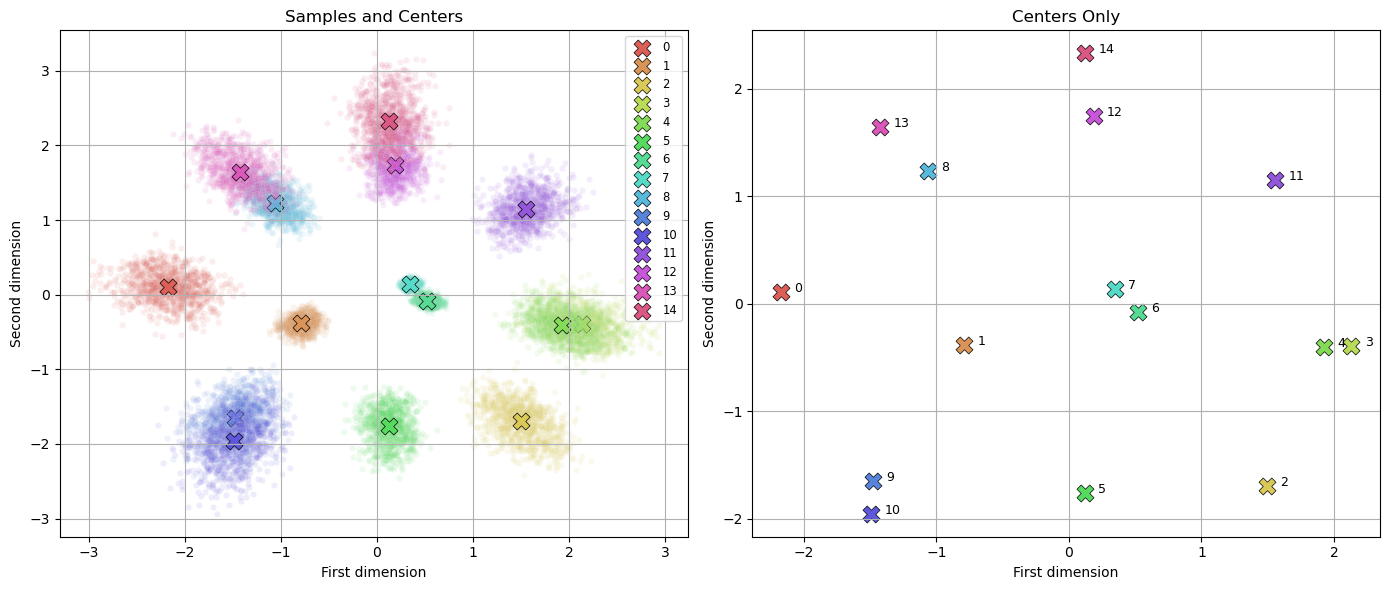

In [22]:
def plot_Z_samples(samples_Z):
    samples_Z = np.array(samples_Z)  
    num_points = samples_Z.shape[1]  
    palette = sns.color_palette("hls", num_points)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    centers = [] 

    for i in range(num_points):
        trace = samples_Z[:, i, :]
        mean_point = trace.mean(axis=0)
        centers.append(mean_point)
        sns.scatterplot(
            ax=axes[0],
            x=trace[:, 0],
            y=trace[:, 1],
            color=palette[i],
            alpha=0.1,
            s=20
        )

        sns.scatterplot(
            ax=axes[0],
            x=[mean_point[0]],
            y=[mean_point[1]],
            color=palette[i],
            marker='X',
            s=150,
            edgecolor='black',
            linewidth=0.5,
            label=f"{i}"
        )

        axes[1].scatter(
            mean_point[0],
            mean_point[1],
            color=palette[i],
            s=150,
            marker='X',
            edgecolor='black',
            linewidth=0.5
        )
        axes[1].text(
            mean_point[0] + 0.1,
            mean_point[1] + 0.001,
            f"{i}",
            fontsize=9
        )

    axes[0].set_title("Samples and Centers")
    axes[0].set_xlabel("First dimension")
    axes[0].set_ylabel("Second dimension")
    axes[0].legend(loc="best", fontsize="small")
    axes[0].grid(True)

    axes[1].set_title("Centers Only")
    axes[1].set_xlabel("First dimension")
    axes[1].set_ylabel("Second dimension")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_Z_samples(samples_Z)

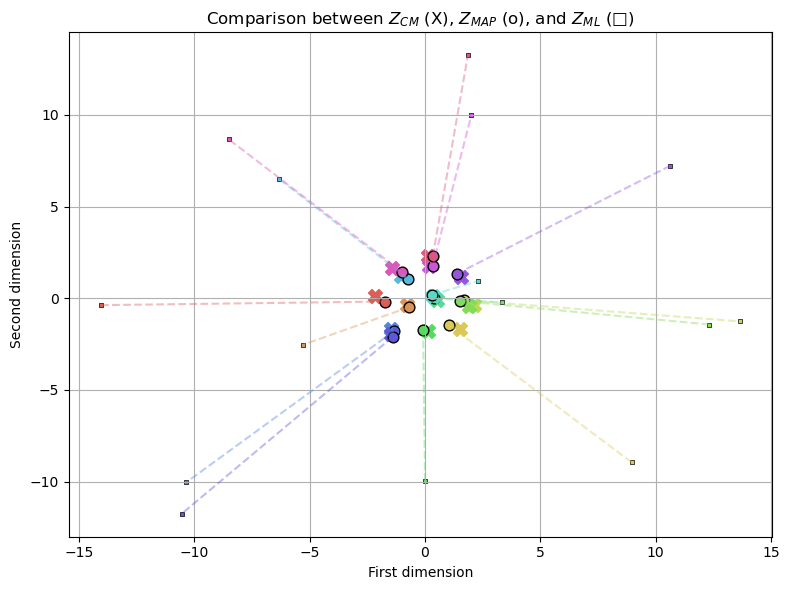

In [23]:
palette = sns.color_palette("hls", n)
plt.figure(figsize=(8, 6))
for i in range(n):
    x_cm, y_cm = Z_CM[i]
    x_map, y_map = Z_MAP[i]
    x_ml, y_ml = Z_ML[i]
    plt.scatter(x_cm, y_cm, color=palette[i], marker='X', s=100, label=f"{i+1} (CM)")
    plt.scatter(x_map, y_map, color=palette[i], marker='o', s=60, edgecolor='black', label=f"{i+1} (MAP)")
    plt.scatter(x_ml, y_ml, color=palette[i], marker='s', s=10, edgecolor='black', linewidth=0.5, label=f"{i+1} (ML)")

    plt.plot([x_cm, x_map], [y_cm, y_map], color=palette[i], linestyle='--', alpha=0.4)
    plt.plot([x_map, x_ml], [y_map, y_ml], color=palette[i], linestyle='--', alpha=0.4)
plt.xlabel("First dimension")
plt.ylabel("Second dimension")
plt.title("Comparison between $Z_{CM}$ (X), $Z_{MAP}$ (o), and $Z_{ML}$ (□)")
plt.grid(True)
plt.tight_layout()
plt.show()

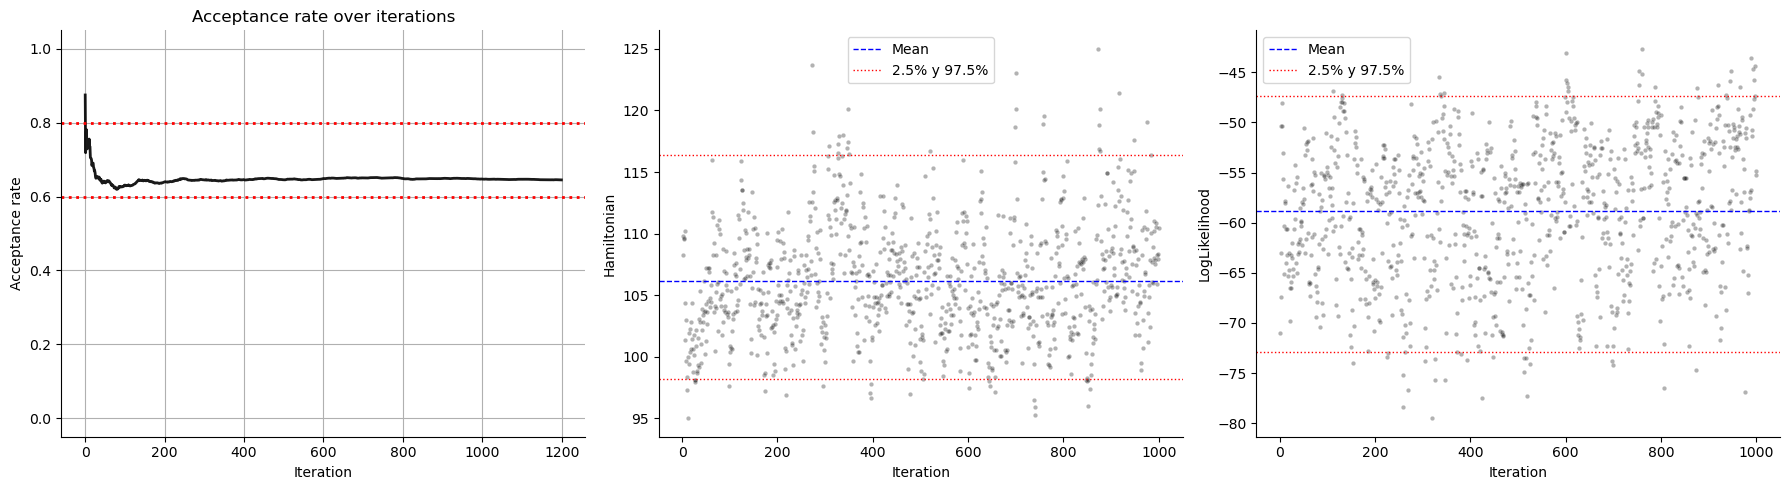

In [24]:
x1 = Hp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({'Iteration': iterations1, 'Values': x1})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

x2 = LogLp
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({'Iteration': iterations2, 'Values': x2})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

# Subplot 1: Acceptance rate
axs[0].plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
axs[0].axhline(0.80, color='red', linestyle=':', linewidth=2)
axs[0].axhline(0.60, color='red', linestyle=':', linewidth=2)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Acceptance rate")
axs[0].set_title("Acceptance rate over iterations")
axs[0].set_ylim(-0.05, 1.05)
axs[0].grid(True)

# Subplot 2: Hamiltonian
sns.scatterplot(ax=axs[1], x='Iteration', y='Values', data=data1, color='black', alpha=0.3, s=10)
axs[1].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Hamiltonian")
axs[1].legend()

# Subplot 3: LogLikelihood
sns.scatterplot(ax=axs[2], x='Iteration', y='Values', data=data2, color='black', alpha=0.3, s=10)
axs[2].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[2].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[2].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("LogLikelihood")
axs[2].legend()

sns.despine()
plt.tight_layout()
plt.show()


In [25]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak on Windows with MKL")

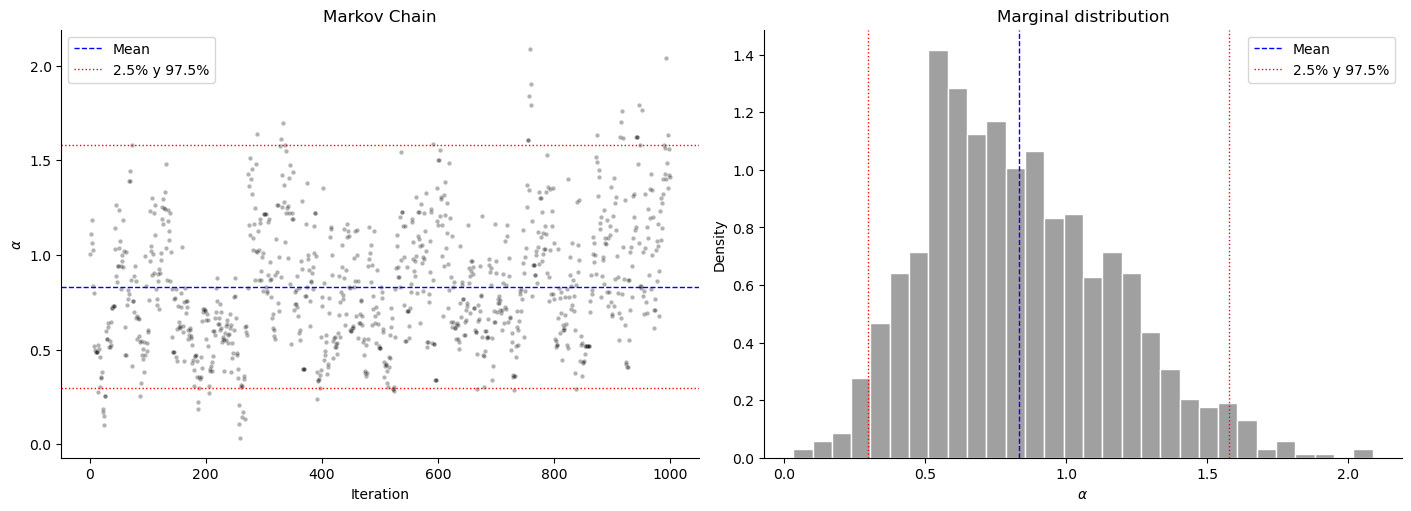

In [26]:
#
x = samples_a
#
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()

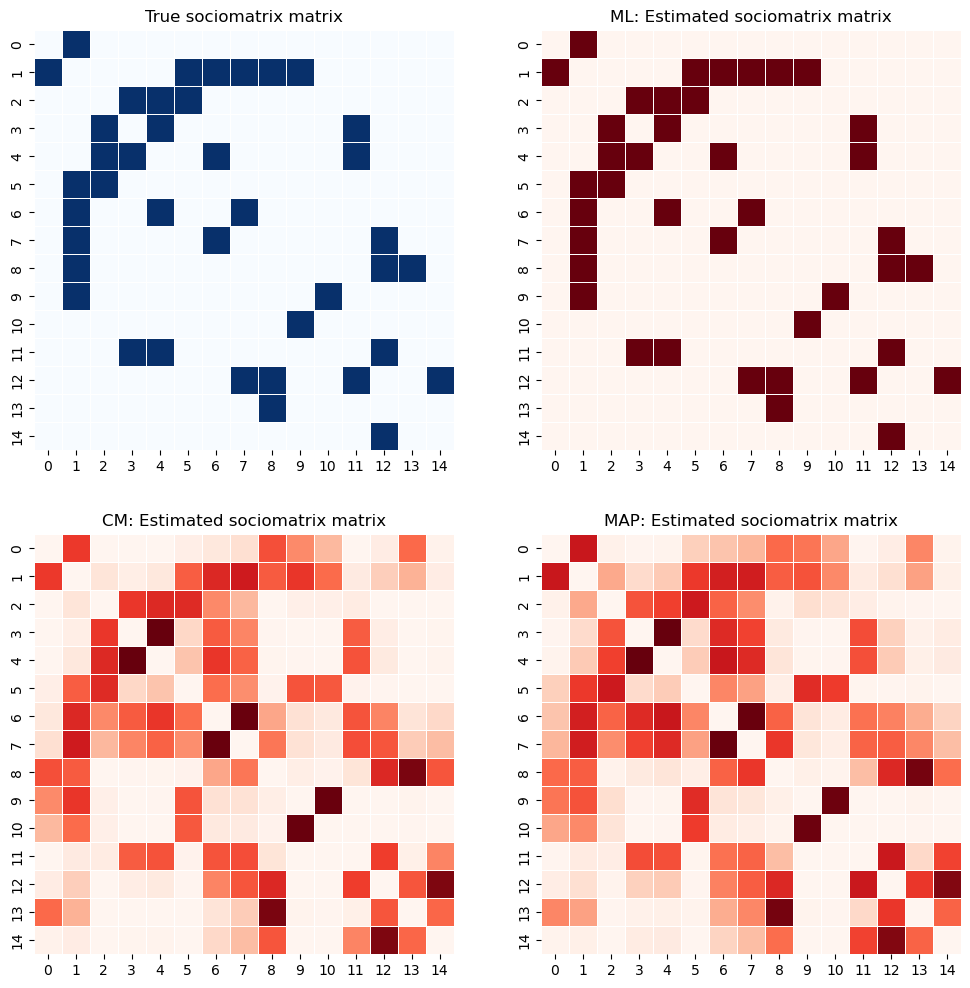

In [27]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM - 0.5 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP - 0.5 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

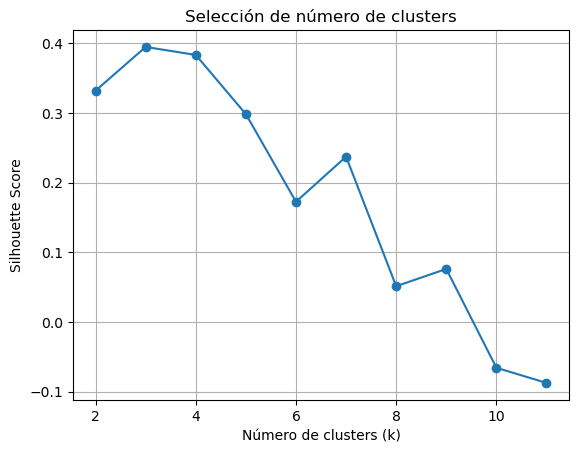

Mejor número de clusters según Silhouette Score: 3


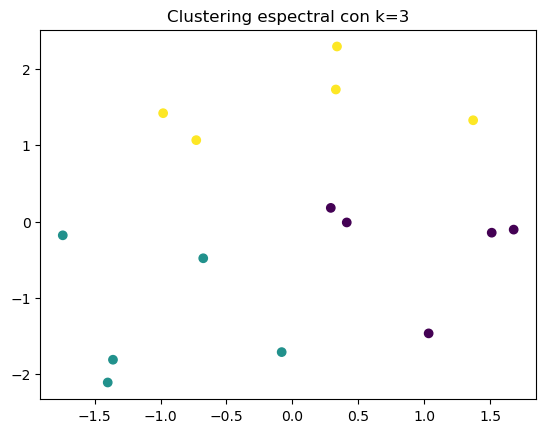

In [28]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Definir el rango de clusters que quieres probar
cluster_range = range(2, 12)
silhouette_scores = []

# Buscar el mejor número de clusters
for k in cluster_range:
    sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
    labels = sc.fit_predict(Z_MAP)
    score = silhouette_score(Z_MAP, labels)
    silhouette_scores.append(score)

# Graficar Silhouette Score vs número de clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Selección de número de clusters")
plt.grid(True)
plt.show()

# Seleccionar el mejor número de clusters
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Mejor número de clusters según Silhouette Score: {best_k}")

# Hacer el clustering final con el mejor número de clusters
sc = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
labels = sc.fit_predict(Z_MAP)

# Visualizar el resultado
plt.scatter(Z_MAP[:, 0], Z_MAP[:, 1], c=labels, cmap='viridis')
plt.title(f"Clustering espectral con k={best_k}")
plt.show()

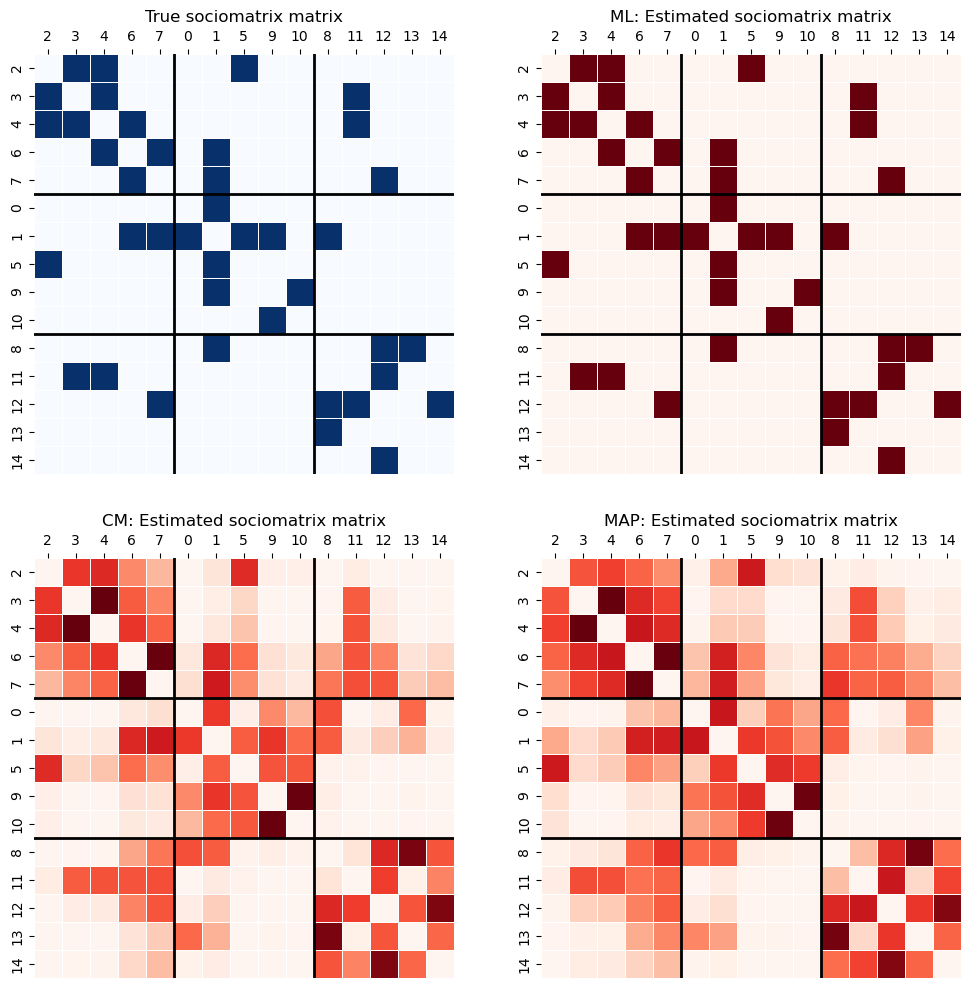

In [29]:
boundaries = []
for i in range(1, len(np.sort(labels))):
    if np.sort(labels)[i] != np.sort(labels)[i-1]:
        boundaries.append(i)

Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM - 0.5 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2)

Y_CM_sorted = Y_CM[np.argsort(labels), :][:, np.argsort(labels)]

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP - 0.5 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2)


Y_MAP_sorted = Y_MAP[np.argsort(labels), :][:, np.argsort(labels)]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
ax1 = sns.heatmap(nx.to_numpy_array(G, dtype=int)[np.argsort(labels), :][:, np.argsort(labels)], annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
for boundary in boundaries:
    ax1.axhline(boundary, color='black', linewidth=2)
    ax1.axvline(boundary, color='black', linewidth=2)

plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
ax2 = sns.heatmap(Y_ML[np.argsort(labels), :][:, np.argsort(labels)], annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
for boundary in boundaries:
    ax2.axhline(boundary, color='black', linewidth=2)
    ax2.axvline(boundary, color='black', linewidth=2)
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
ax3 = sns.heatmap(Y_CM_sorted, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax3.xaxis.set_ticks_position('top')
ax3.xaxis.set_label_position('top')
for boundary in boundaries:
    ax3.axhline(boundary, color='black', linewidth=2)
    ax3.axvline(boundary, color='black', linewidth=2)
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
ax4 = sns.heatmap(Y_MAP_sorted, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white',
            xticklabels=np.argsort(labels), yticklabels=np.argsort(labels))
ax4.xaxis.set_ticks_position('top')
ax4.xaxis.set_label_position('top')
for boundary in boundaries:
    ax4.axhline(boundary, color='black', linewidth=2)
    ax4.axvline(boundary, color='black', linewidth=2)
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

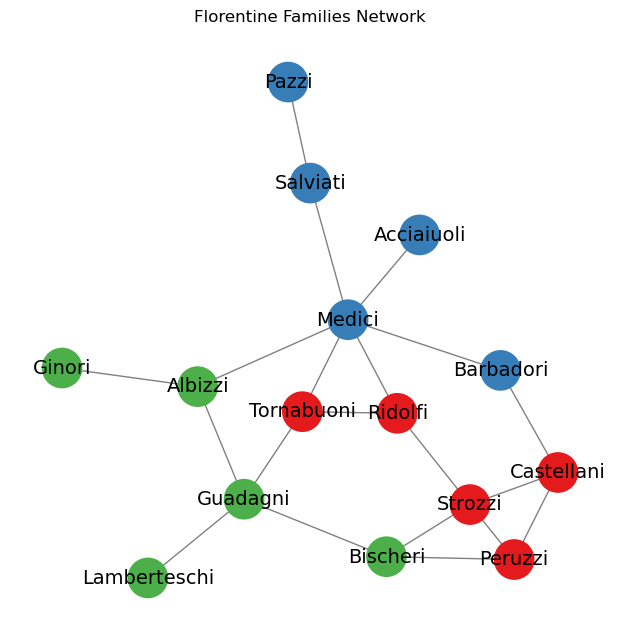

In [30]:
plt.figure(figsize=(6,6))
cmap = plt.colormaps.get_cmap('Set1')
nx.draw(G, nx.spring_layout(G, seed=4),with_labels=False, node_color=[cmap(label) for label in labels], edge_color='gray', node_size=800)
node_mapping_inv = {v: k for k, v in node_mapping.items()}
nx.draw_networkx_labels(G, nx.spring_layout(G, seed=4), labels=node_mapping_inv, font_size=14, font_color='black')
plt.title("Florentine Families Network")
plt.show()

# Model checking

## Posterior predictive checking

In [111]:
def sample_adjacency_matrix(P):
    """
    Sample a binary (0/1) adjacency matrix from a probability matrix P.
    
    Parameters:
        P (np.ndarray): Probability matrix of shape (n, n), with entries in [0,1]
        
    Returns:
        A (np.ndarray): Symmetric adjacency matrix sampled from Bernoulli(P)
    """
    A = np.random.binomial(1, P)

    A = np.triu(A, k=1)
    A = A + A.T
    
    return A

def compute_network_statistics(G):
    """Compute network statistics for a single graph (largest connected component)."""
    
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    degrees = np.array([deg for _, deg in G.degree()])

    stats = {
        'Density': nx.density(G),
        'Transitivity': nx.transitivity(G),
        'Assortativity': nx.degree_assortativity_coefficient(G),
        'Average Degree': degrees.mean(),
        'Degree SD': degrees.std(),
        'Average Path Length': nx.average_shortest_path_length(G)
    }

    return stats



In [112]:
def posterior_predictive_check(samples_Z, samples_a, real_stats):
    """
    Perform posterior predictive checks and return summary statistics including Bayesian p-values.
    
    Parameters:
        samples_Z (np.ndarray): Latent position samples (n_samples, n_nodes, d)
        samples_a (np.ndarray): Parameter samples (n_samples,)
        real_stats (dict): Real network statistics {'density': val, 'transitivity': val, ...}
        
    Returns:
        df_stats (pd.DataFrame): Sampled network statistics
        bayes_pvals (dict): Bayesian p-values for each statistic
    """
    stats_list = []

    num_samples = samples_a.shape[0]
    
    for l in range(num_samples):
        P = np.zeros((samples_Z.shape[1], samples_Z.shape[1]))
        for i in range(samples_Z.shape[1]):
            for j in range(samples_Z.shape[1]):
                if i != j:
                    P[i, j] = expit(samples_a[l] - 0.5 * np.linalg.norm(samples_Z[l,i,:] - samples_Z[l,j,:])**2)
        
        A = sample_adjacency_matrix(P)
        G_sample = nx.from_numpy_array(A)
        
        stats = compute_network_statistics(G_sample)
        stats_list.append(stats)
    
    df_stats = pd.DataFrame(stats_list)

    bayes_pvals = {}
    for stat_name in df_stats.columns:
        sim_vals = df_stats[stat_name].values
        real_val = real_stats.get(stat_name, None)
        if real_val is not None:
            p_val = np.mean(sim_vals >= real_val)
            bayes_pvals[stat_name] = p_val

    stats_names = df_stats.columns.tolist()

    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, stat_name in enumerate(stats_names):
        if i >= 6:
            break
        
        data = df_stats[stat_name].values
        real_value = real_stats.get(stat_name, None)
        mean_val = np.mean(data)
        q_low, q_high = np.quantile(data, [0.025, 0.975])
        
        ax = axes[i]
        ax.hist(data, bins=25, color='lightgray',edgecolor='white', alpha=0.7, density=True)
        ax.axvline(q_low, color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
        ax.axvline(q_high, color='red', linestyle=':', linewidth=1)
        ax.axvline(mean_val, color='blue', linestyle='--', linewidth=1, label='Mean')
        if real_value is not None:
            ax.axvline(real_value, color='black', linestyle='-', linewidth=2, label='True value')
        
        title = f'{stat_name} (p = {bayes_pvals.get(stat_name, np.nan):.4f})'
        ax.set_title(title)
        ax.legend()
    
    for j in range(i+1, 6):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

    #return df_stats, bayes_pvals


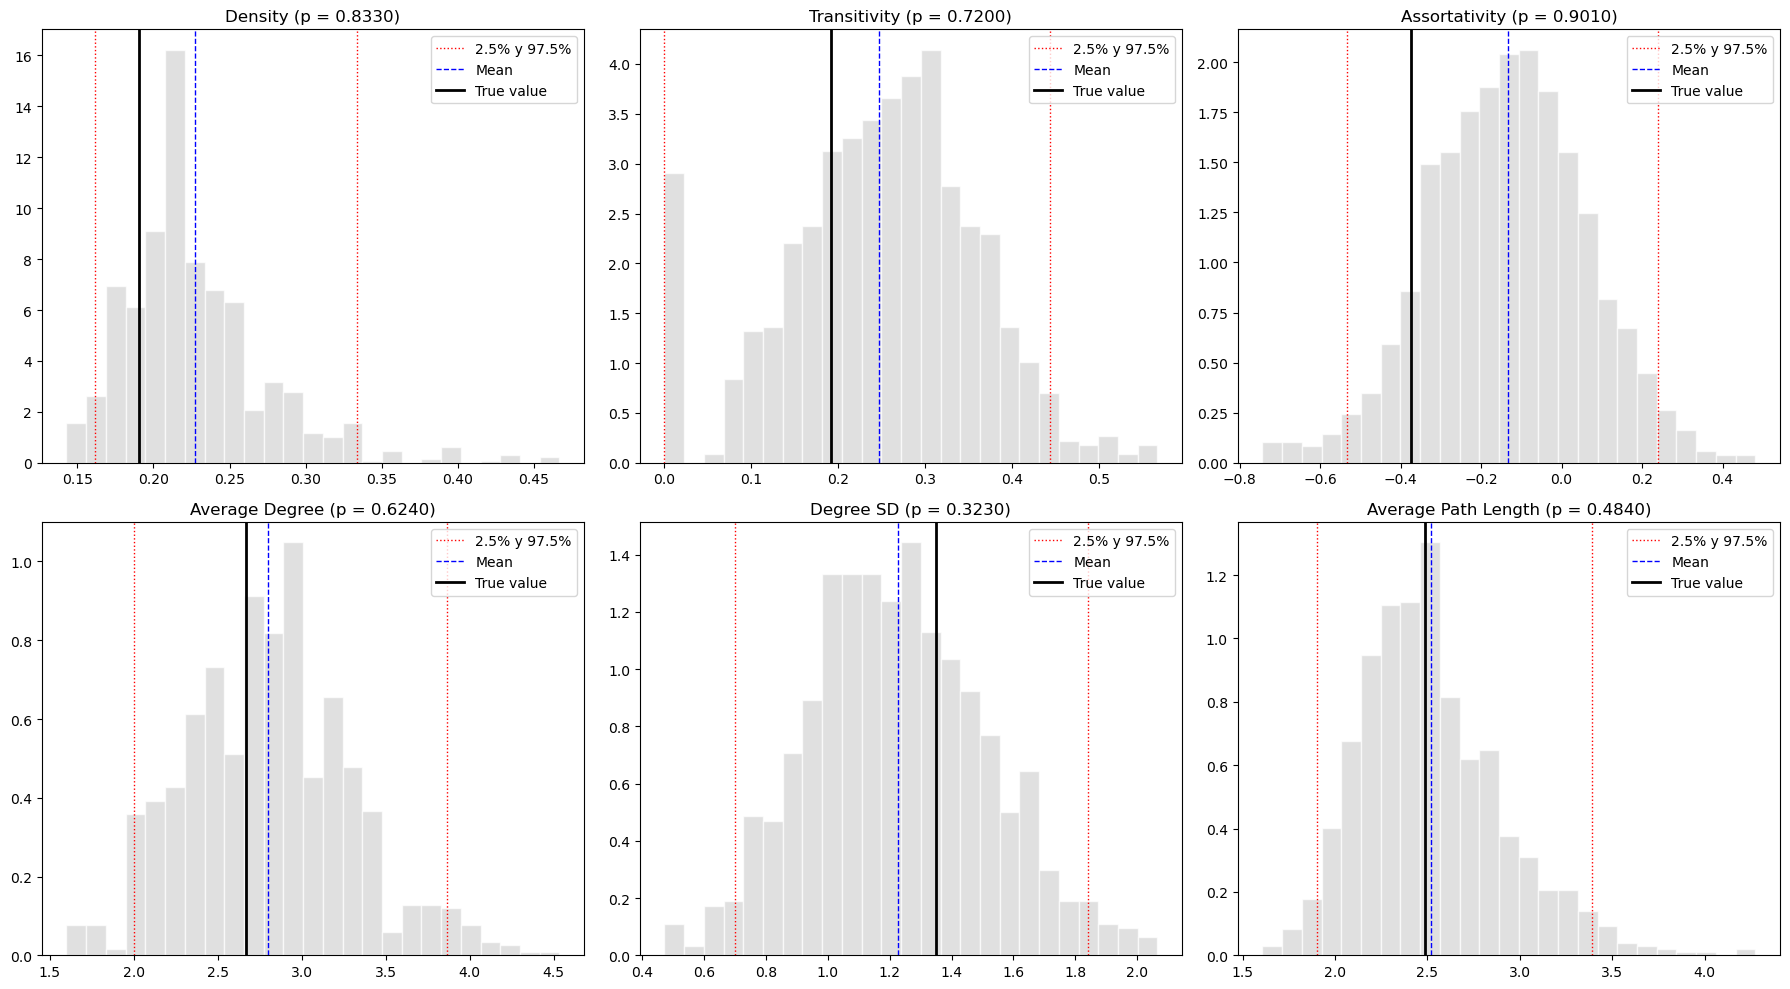

In [113]:
posterior_predictive_check(samples_Z,samples_a,compute_network_statistics(G))

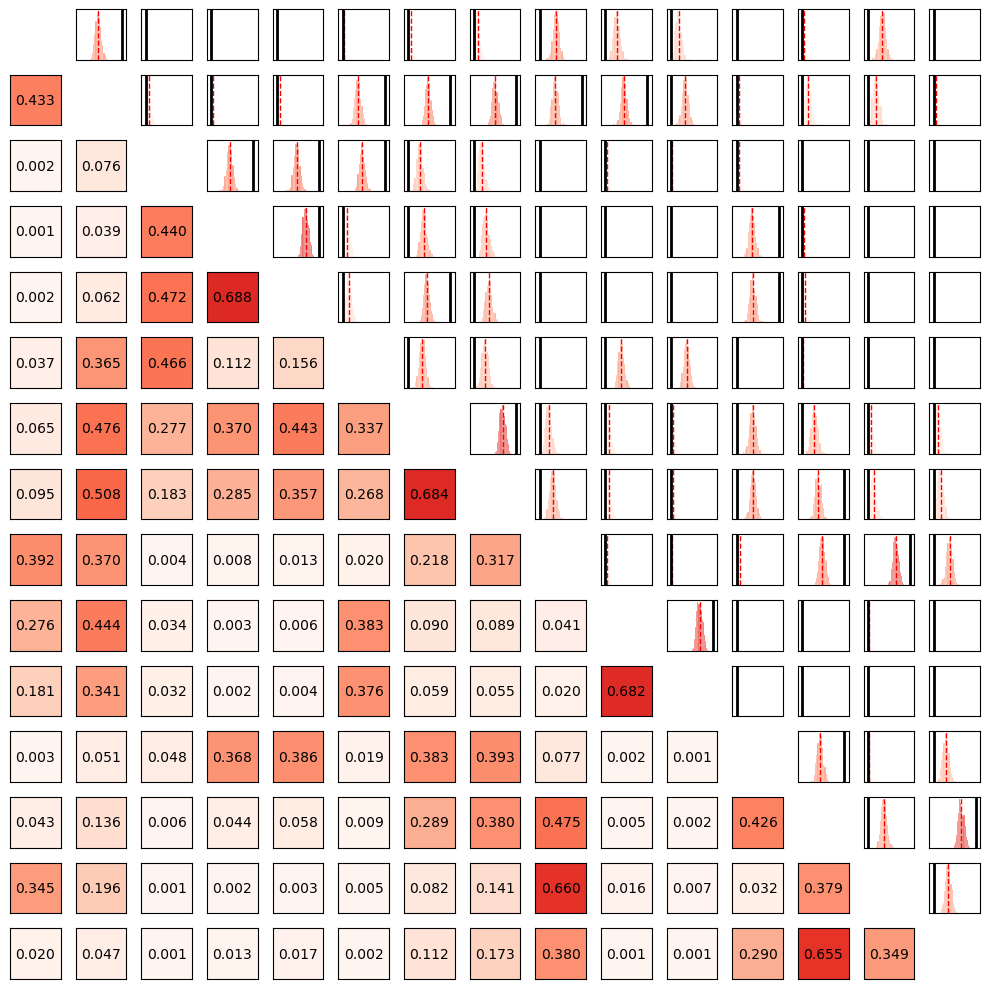

In [ ]:
def plot_pairwise_posteriors(samples_Z, samples_a, A_real):
    """
    Visualize pairwise posterior distributions for model.

    Parámetros:
        samples_Z (np.ndarray): Latent positions (num_samples, n, d)
        samples_a (np.ndarray): Parameter (num_samples,)
        A_real (np.ndarray): Sociomatrix (n, n)
    """
    num_samples, n, _ = samples_Z.shape
    probs_samples = np.zeros((num_samples, n, n))

    for l in range(num_samples):
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist_sq = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])**2
                    probs_samples[l, i, j] = expit(samples_a[l] - 0.5 * dist_sq)

    mean_probs = probs_samples.mean(axis=0)


    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    cmap = sns.color_palette("Reds", as_cmap=True)
    
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.set_xticks([])
            ax.set_yticks([])
            
            if i > j:
                color = cmap(mean_probs[i, j])
                ax.set_facecolor(color)
                ax.text(0.5, 0.5, f"{mean_probs[i, j]:.3f}", ha='center', va='center', fontsize=10)
            elif i < j:
                vals = probs_samples[:, i, j]
                mean_val = vals.mean()
                real_val = A_real[i, j]
                
                sns.histplot(vals, bins=15, ax=ax, color=cmap(mean_val), edgecolor='white')
                ax.set_xlim(-0.1, 1.1)
                ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label='Mean')
                ax.axvline(real_val, color='black', linestyle='-', linewidth=2.0, label='Real')
            else:
                # Diagonal
                ax.set_facecolor('white')
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_pairwise_posteriors(samples_Z, samples_a, Y_ML)

## Model comparison criteria

In [109]:
def compute_log_likelihood(A_obs, samples_Z, samples_a):
    """
    Compute log-likelihood for each sample and pair of nodes.

    Returns:
        log_lik: np.ndarray de shape (L, n, n)
    """
    L, n, _ = samples_Z.shape
    log_lik = np.zeros((L, n, n))

    for l in range(L):
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist_sq = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])**2
                    p_ij = expit(samples_a[l] - 0.5 * dist_sq)
                    if A_obs[i, j] == 1:
                        log_lik[l, i, j] = np.log(p_ij + 1e-10)
                    else:
                        log_lik[l, i, j] = np.log(1 - p_ij + 1e-10)
    return log_lik

def compute_WAIC(log_lik):
    """
    Compute  WAIC using loglikelihood matrix.
    """
    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0) + 1e-10))  # log pointwise predictive density
    p_waic = np.sum(np.var(log_lik, axis=0))                         # penalization term
    waic = -2 * (lppd - p_waic)
    return waic

def compute_DIC(log_lik, A_obs, samples_Z, samples_a):
    """
    Compute the Deviance Information Criterion (DIC).
    """
    deviance_samples = -2 * np.sum(log_lik, axis=(1, 2))  
    mean_deviance = np.mean(deviance_samples)


    Z_mean = np.mean(samples_Z, axis=0)
    a_mean = np.mean(samples_a)


    n = A_obs.shape[0]
    log_lik_mean = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_sq = np.linalg.norm(Z_mean[i] - Z_mean[j])**2
                p_ij = expit(a_mean - 0.5 * dist_sq)
                if A_obs[i, j] == 1:
                    log_lik_mean[i, j] = np.log(p_ij + 1e-10)
                else:
                    log_lik_mean[i, j] = np.log(1 - p_ij + 1e-10)
    deviance_mean = -2 * np.sum(log_lik_mean)

    p_dic = mean_deviance - deviance_mean
    dic = mean_deviance + p_dic
    return dic


In [114]:
log_lik = compute_log_likelihood(Y_ML, samples_Z, samples_a)
waic = compute_WAIC(log_lik)
dic = compute_DIC(log_lik, Y_ML, samples_Z, samples_a)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")


WAIC: 90.8942
DIC: 91.4118


## Prior predictive checks

In [136]:
samples_Z_prior = 0.1*np.random.randn(number_of_samples, n, 2)
samples_a_prior = np.random.randn(number_of_samples)

c:\Users\carlo\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


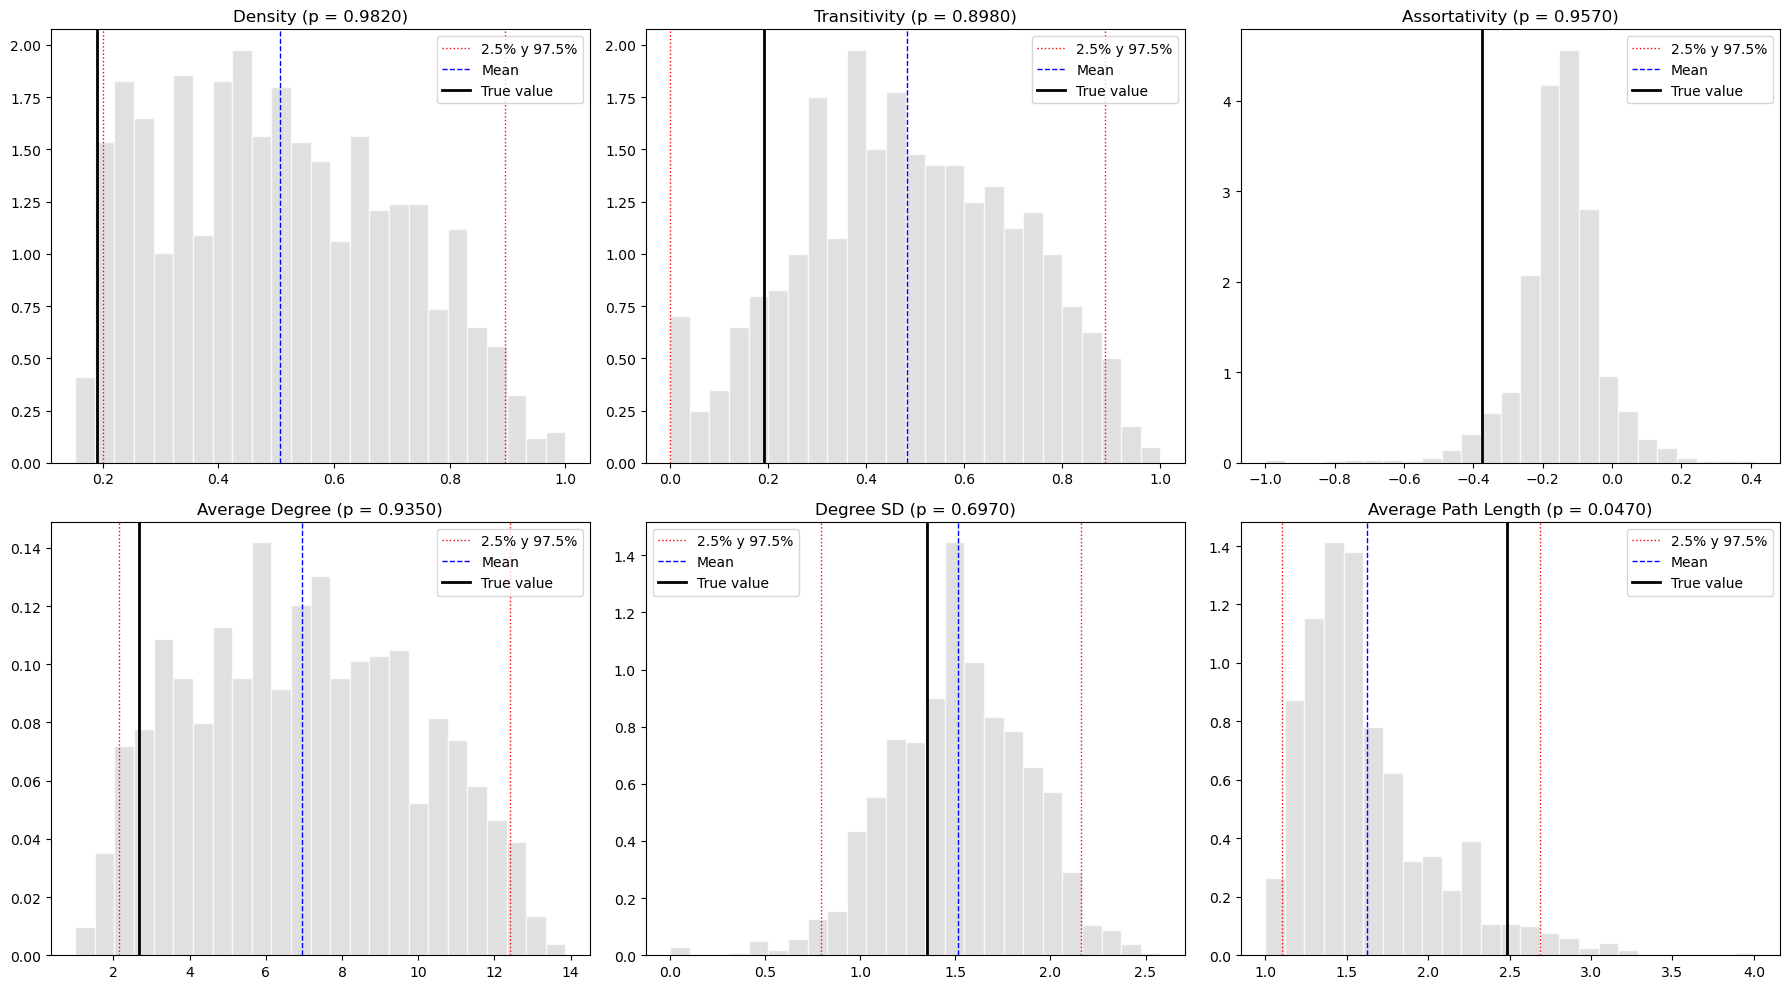

In [137]:
posterior_predictive_check(samples_Z_prior,samples_a_prior,compute_network_statistics(G))

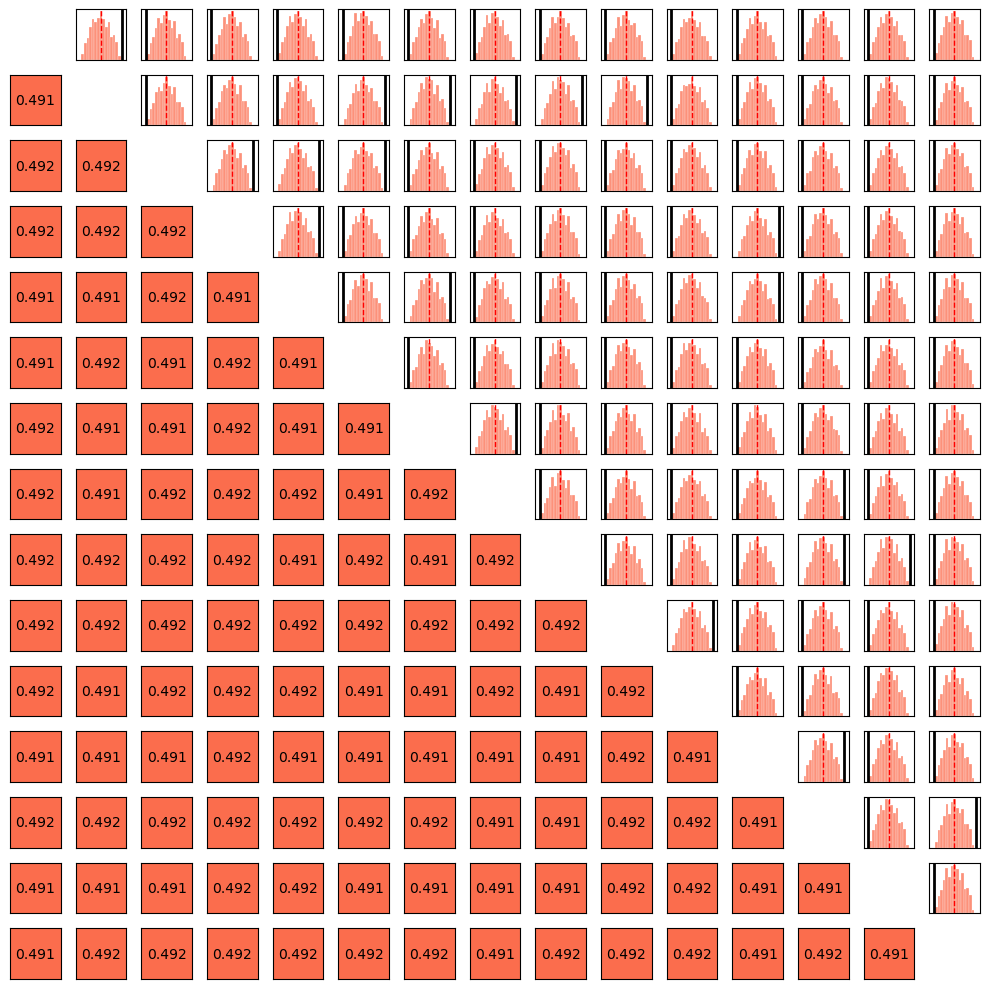

In [138]:
plot_pairwise_posteriors(samples_Z_prior, samples_a_prior, Y_ML)

In [139]:
log_lik_prior = compute_log_likelihood(Y_ML, samples_Z_prior, samples_a_prior)
waic_prior = compute_WAIC(log_lik_prior)
dic_prior = compute_DIC(log_lik_prior, Y_ML, samples_Z_prior, samples_a_prior)


print(f"WAIC: {waic_prior:.4f}")
print(f"DIC: {dic_prior:.4f}")

WAIC: 397.7726
DIC: 375.5641


## Residual analysis

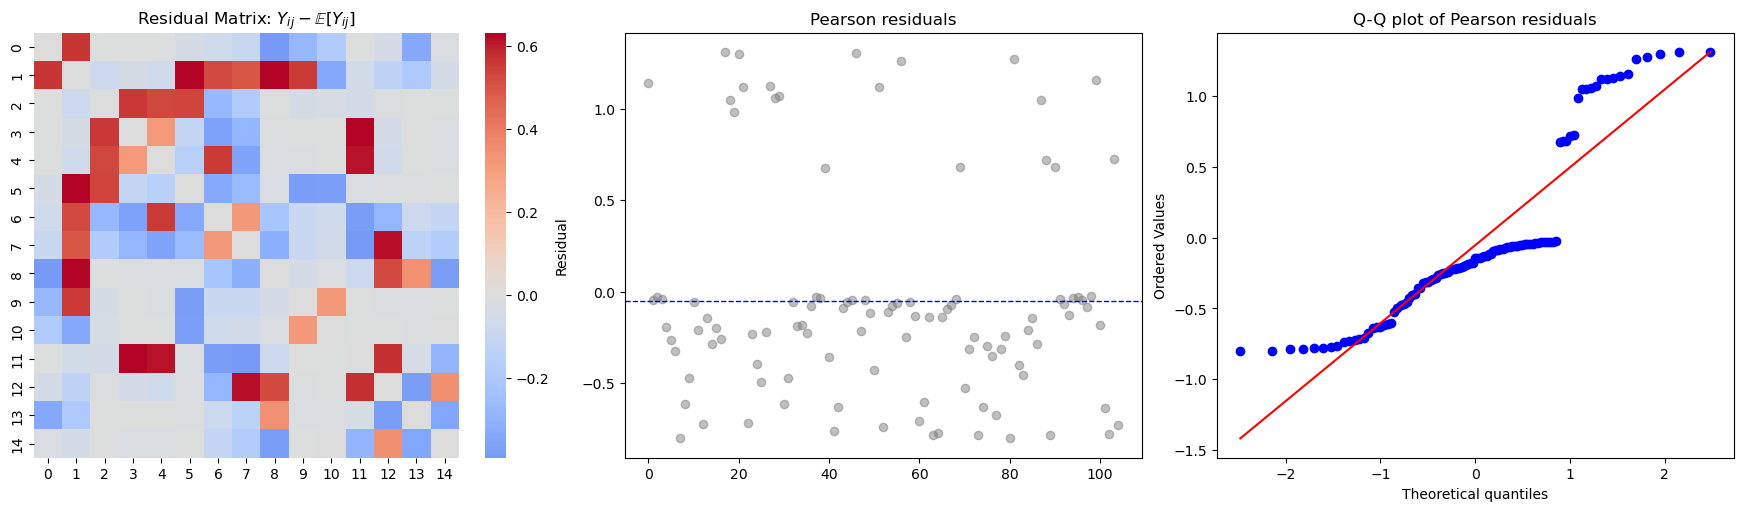

In [169]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit
from scipy import stats 

def residual_analysis(A_obs, samples_Z, samples_a):
    """
    Perform residual analysis comparing observed adjacency to posterior predictive means.
    
    Parameters:
        A_obs (np.ndarray): Observed adjacency matrix (n x n)
        samples_Z (np.ndarray): Latent position samples (L, n, d)
        samples_a (np.ndarray): Samples of intercept (L,)
        
    Returns:
        residuals (np.ndarray): Matrix of standardized Pearson residuals
    """
    n = A_obs.shape[0]
    L = samples_a.shape[0]
    
    # Compute posterior mean of the adjacency matrix
    E_A = np.zeros((n, n))
    for l in range(L):
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist_sq = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])**2
                    p_ij = expit(samples_a[l] - 0.5 * dist_sq)
                    E_A[i, j] += p_ij
    E_A /= L

    # Compute Pearson residuals (with numerical stability)
    epsilon = 1e-6
    residuals = (A_obs - E_A) / np.sqrt(E_A * (1 - E_A) + epsilon)

    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    # Heatmap of residuals
    sns.heatmap(A_obs - E_A, ax=axes[0], cmap="coolwarm", center=0, square=True, 
                cbar_kws={'label': 'Residual'})
    axes[0].set_title("Residual Matrix: $Y_{ij} - \mathbb{E}[Y_{ij}]$")

    # Scatter plot of upper triangular residuals
    upper_residuals = residuals[np.triu_indices(n, k=1)]
    axes[1].plot(upper_residuals, color='gray', alpha=0.5, marker='o', linestyle='None')
    axes[1].axhline(upper_residuals.mean(), color='blue', linestyle='--', linewidth=1, label='Mean')

    axes[1].set_title("Pearson residuals")

    # Q-Q plot
    stats.probplot(upper_residuals, dist="norm", plot=axes[2])
    axes[2].set_title("Q-Q plot of Pearson residuals")

    plt.show()

    return residuals  

residuals = residual_analysis(Y_ML, samples_Z, samples_a)


In [164]:
import numpy as np
from scipy.stats import shapiro, anderson, kstest, norm, skew, kurtosis
import warnings

def residual_diagnostics(residuals, verbose=True):
    """
    Compute numerical diagnostics on residuals from a network model.
    
    Parameters:
        residuals (np.ndarray): Symmetric matrix of Pearson residuals (n x n)
        verbose (bool): If True, prints the diagnostics
        
    Returns:
        diagnostics (dict): Dictionary with numerical metrics
    """
    # Extract upper triangle of residuals (excluding diagonal)
    res_flat = residuals[np.triu_indices(residuals.shape[0], k=1)]

    diagnostics = {}

    # Mean and standard deviation
    diagnostics['mean'] = np.mean(res_flat)
    diagnostics['std'] = np.std(res_flat)

    # Skewness and kurtosis
    diagnostics['skewness'] = skew(res_flat)
    diagnostics['kurtosis'] = kurtosis(res_flat, fisher=False)  # Normal = 3

    # Proportion of values outside standard normal bounds
    diagnostics['prop_outside_95'] = np.mean(np.abs(res_flat) > 1.96)
    diagnostics['prop_outside_99'] = np.mean(np.abs(res_flat) > 2.58)

    # Normality tests
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            stat, p = shapiro(res_flat)
            diagnostics['shapiro_W'] = stat
            diagnostics['shapiro_p'] = p
        except:
            diagnostics['shapiro_W'] = np.nan
            diagnostics['shapiro_p'] = np.nan
        
        anderson_result = anderson(res_flat)
        diagnostics['anderson_stat'] = anderson_result.statistic
        diagnostics['anderson_crit_vals'] = anderson_result.critical_values.tolist()
        diagnostics['anderson_sig_levels'] = anderson_result.significance_level.tolist()

        ks_stat, ks_p = kstest(res_flat, 'norm')
        diagnostics['ks_stat'] = ks_stat
        diagnostics['ks_p'] = ks_p

    if verbose:
        print("\n--- Residual Diagnostics ---")
        print(f"Mean: {diagnostics['mean']:.4f}")
        print(f"Std Dev: {diagnostics['std']:.4f}")
        print(f"Skewness: {diagnostics['skewness']:.4f}")
        print(f"Kurtosis: {diagnostics['kurtosis']:.4f}")
        print(f"Proportion |residual| > 1.96 (95%): {diagnostics['prop_outside_95']:.4%}")
        print(f"Proportion |residual| > 2.58 (99%): {diagnostics['prop_outside_99']:.4%}")
        print(f"Shapiro-Wilk W: {diagnostics['shapiro_W']:.4f}, p = {diagnostics['shapiro_p']:.4f}")
        print(f"Anderson-Darling stat: {diagnostics['anderson_stat']:.4f}")
        print(f"K-S stat: {diagnostics['ks_stat']:.4f}, p = {diagnostics['ks_p']:.4f}")
        print("----------------------------\n")

    #return diagnostics

residual_diagnostics(residuals)


--- Residual Diagnostics ---
Mean: -0.0537
Std Dev: 0.5863
Skewness: 1.0579
Kurtosis: 3.1700
Proportion |residual| > 1.96 (95%): 0.0000%
Proportion |residual| > 2.58 (99%): 0.0000%
Shapiro-Wilk W: 0.8410, p = 0.0000
Anderson-Darling stat: 6.5923
K-S stat: 0.3185, p = 0.0000
----------------------------



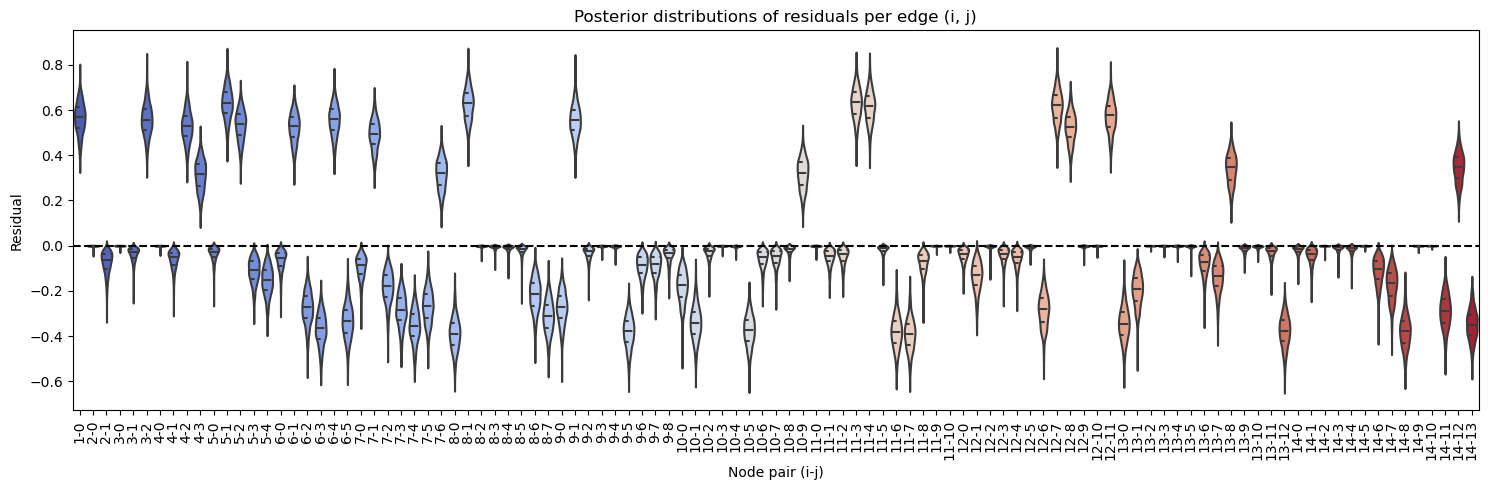

In [165]:
def residual_distributions(A_obs, samples_Z, samples_a):
    """
    Compute posterior distributions of residuals for each (i,j) pair in the lower triangle.
    
    Parameters:
        A_obs (np.ndarray): Observed adjacency matrix (n x n)
        samples_Z (np.ndarray): Latent positions (L, n, d)
        samples_a (np.ndarray): Intercept samples (L,)
        
    Returns:
        residuals_dict: dict of (i,j) -> list of residual samples
    """
    n = A_obs.shape[0]
    L = samples_a.shape[0]
    residuals_dict = {}

    for i in range(n):
        for j in range(i):
            residual_samples = []
            for l in range(L):
                z_i = samples_Z[l, i]
                z_j = samples_Z[l, j]
                dist_sq = np.sum((z_i - z_j)**2)
                p_ij = expit(samples_a[l] - 0.5 * dist_sq)
                res = A_obs[i, j] - p_ij
                residual_samples.append(res)
            residuals_dict[(i, j)] = np.array(residual_samples)
    
    return residuals_dict

def plot_residual_distributions(residuals_dict, n):
    """
    Plot violinplots or boxplots of residual distributions for each (i,j) in lower triangle.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    data = []
    for (i, j), residuals in residuals_dict.items():
        for r in residuals:
            data.append({'pair': f'{i}-{j}', 'residual': r})

    df = pd.DataFrame(data)

    plt.figure(figsize=(15, 5))
    sns.violinplot(data=df, x='pair', y='residual', inner='quartile', scale='width', palette='coolwarm')
    plt.xticks(rotation=90)
    plt.title("Posterior distributions of residuals per edge (i, j)")
    plt.axhline(0, color='black', linestyle='--')
    plt.ylabel("Residual")
    plt.xlabel("Node pair (i-j)")
    plt.tight_layout()
    plt.show()

residuals_dict = residual_distributions(Y_ML, samples_Z, samples_a)
plot_residual_distributions(residuals_dict, n)

In [167]:
def summarize_residuals_bayesian(residuals_dict):
    """
    Compute summary diagnostics from posterior distributions of residuals.
    
    Returns:
        df_summary: DataFrame with mean, std, 95% CI, z-score, and bayesian p-value for each (i,j)
    """
    summary = []

    for (i, j), res_samples in residuals_dict.items():
        mean_r = np.mean(res_samples)
        std_r = np.std(res_samples)
        ci_lower, ci_upper = np.percentile(res_samples, [2.5, 97.5])
        z_score = mean_r / (std_r + 1e-8)
        p_value = np.mean(res_samples > 0)

        summary.append({
            "pair": f"{i}-{j}",
            "mean": mean_r,
            "std": std_r,
            "z_score": z_score,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "bayes_p": p_value
        })

    df_summary = pd.DataFrame(summary)
    return df_summary
residual_summary = summarize_residuals_bayesian(residuals_dict)
residual_summary

,pair,mean,std,z_score,ci_lower,ci_upper,bayes_p
0,1-0,0.564741,0.068463,8.248817,0.422098,6.879578e-01,1.0
1,2-0,-0.002029,0.004245,-0.478015,-0.013758,-6.107709e-06,0.0
2,2-1,-0.076247,0.050207,-1.518638,-0.196362,-1.254743e-02,0.0
3,3-0,-0.000910,0.002420,-0.376186,-0.006375,-1.266844e-06,0.0
4,3-1,-0.038943,0.031877,-1.221696,-0.119771,-3.595463e-03,0.0
...,...,...,...,...,...,...,...
100,14-9,-0.001155,0.002755,-0.419255,-0.008654,-1.066204e-06,0.0
101,14-10,-0.000506,0.001411,-0.358360,-0.004249,-1.279212e-07,0.0
102,14-11,-0.289490,0.073446,-3.941541,-0.445121,-1.566426e-01,0.0
103,14-12,0.345332,0.067344,5.127892,0.210110,4.692738e-01,1.0


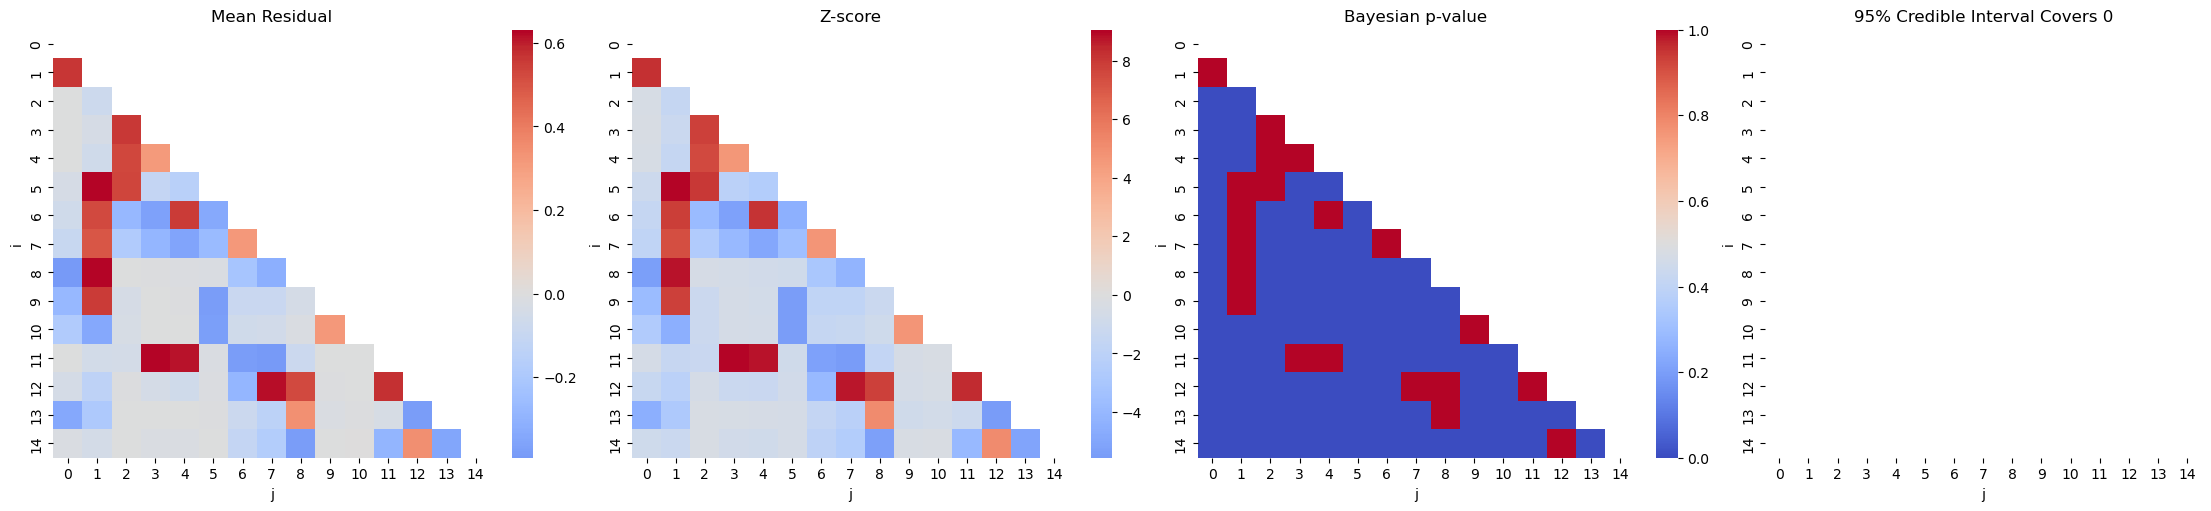

In [171]:
def analyze_residuals_matrix(residuals_dict, n):
    """
    Build matrices of residual summaries: mean, z-score, bayesian p-value, coverage.
    
    Returns:
        dict of summary matrices
    """
    mean_mat = np.full((n, n), np.nan)
    zscore_mat = np.full((n, n), np.nan)
    pval_mat = np.full((n, n), np.nan)
    coverage_mat = np.full((n, n), np.nan)

    for (i, j), samples in residuals_dict.items():
        mean_r = np.mean(samples)
        std_r = np.std(samples) + 1e-6
        z_score = mean_r / std_r
        p_val = np.mean(samples > 0)
        ci_lower, ci_upper = np.percentile(samples, [2.5, 97.5])
        coverage = int(ci_lower <= 0 <= ci_upper)  # 1 if includes 0, else 0

        mean_mat[i, j] = mean_r
        zscore_mat[i, j] = z_score
        pval_mat[i, j] = p_val
        coverage_mat[i, j] = coverage

    return {
        "mean": mean_mat,
        "zscore": zscore_mat,
        "bayes_p": pval_mat,
        "coverage": coverage_mat
    }

def plot_residual_summary_matrices(summary_matrices):
    """
    Plot residual summary matrices as heatmaps.
    """
    fig, axes = plt.subplots(1, 4, figsize=(22, 5), constrained_layout=True)
    cmap = "coolwarm"

    sns.heatmap(summary_matrices["mean"], ax=axes[0], cmap=cmap, center=0)
    axes[0].set_title("Mean Residual")

    sns.heatmap(summary_matrices["zscore"], ax=axes[1], cmap=cmap, center=0)
    axes[1].set_title("Z-score")

    sns.heatmap(summary_matrices["bayes_p"], ax=axes[2], cmap=cmap, vmin=0, vmax=1)
    axes[2].set_title("Bayesian p-value")

    sns.heatmap(summary_matrices["coverage"], ax=axes[3], cmap="Greys", vmin=0, vmax=1, cbar=False)
    axes[3].set_title("95% Credible Interval Covers 0")

    for ax in axes:
        ax.set_xlabel("j")
        ax.set_ylabel("i")
    plt.show()
residuals_dict = residual_distributions(Y_ML, samples_Z, samples_a)
summary_matrices = analyze_residuals_matrix(residuals_dict, Y_ML.shape[0])
plot_residual_summary_matrices(summary_matrices)


## Prediction evaluation

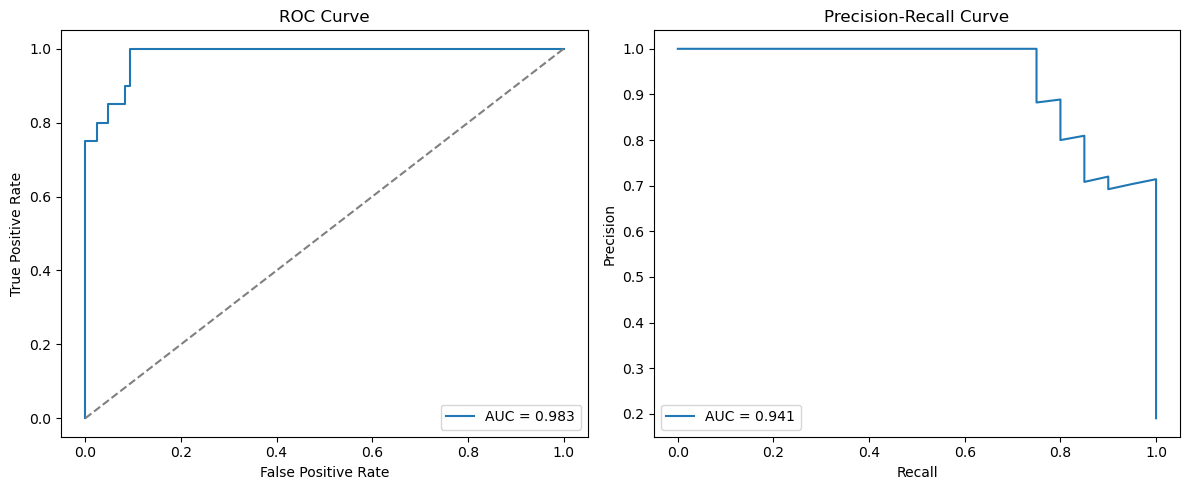

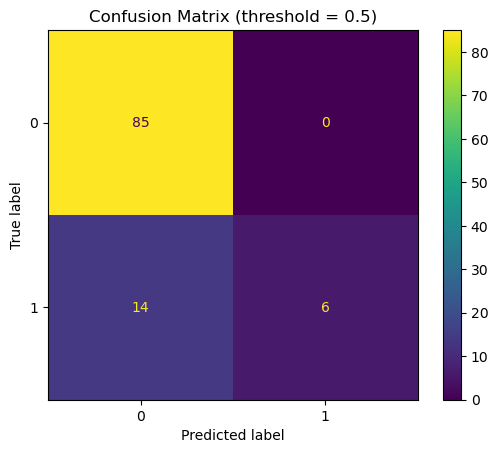

In [174]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from scipy.special import expit
import matplotlib.pyplot as plt
import numpy as np

def posterior_connection_probs(samples_Z, samples_a):
    """
    Compute posterior mean probabilities for each (i, j)
    """
    L, n, _ = samples_Z.shape
    probs = np.zeros((n, n))
    
    for l in range(L):
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist_sq = np.sum((samples_Z[l, i] - samples_Z[l, j])**2)
                    p_ij = expit(samples_a[l] - 0.5 * dist_sq)
                    probs[i, j] += p_ij
    probs /= L
    return probs

def roc_prc_analysis(A_obs, prob_mean):
    """
    Generate ROC, PRC, AUC, and confusion matrix
    """
    triu_mask = np.triu_indices_from(A_obs, k=1)
    
    # Forzar a binario
    y_true = (A_obs[triu_mask] > 0.5).astype(int)
    y_score = prob_mean[triu_mask].flatten()
    
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # PRC
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    prc_auc = auc(recall, precision)
    
    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[0].set_title("ROC Curve")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()

    axes[1].plot(recall, precision, label=f"AUC = {prc_auc:.3f}")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
    # Confusion matrix with threshold 0.5
    y_pred = (y_score > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title("Confusion Matrix (threshold = 0.5)")
    plt.show()
    
    return {
        "roc_auc": roc_auc,
        "prc_auc": prc_auc,
        "confusion_matrix": cm
    }

# --- Uso ---
prob_mean = posterior_connection_probs(samples_Z, samples_a)
metrics = roc_prc_analysis(Y_ML, prob_mean)


In [176]:
prob_mean.shape

(15, 15)

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def posterior_connection_probs(samples_Z, samples_a):
    """
    Devuelve una lista de matrices de probabilidad de conexión p_ij para cada muestra posterior.
    """
    L, n, d = samples_Z.shape
    prob_matrices = []

    for l in range(L):
        P = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                dist_sq = np.sum((samples_Z[l, i] - samples_Z[l, j])**2)
                p_ij = 1 / (1 + np.exp(- (samples_a[l] - 0.5 * dist_sq)))
                P[i, j] = p_ij
                P[j, i] = p_ij
        prob_matrices.append(P)

    return prob_matrices

def bayesian_roc_curves(A_obs, prob_matrices):
    """
    Calcula curvas ROC y AUC para cada muestra del posterior.
    """
    n = A_obs.shape[0]
    y_true = A_obs[np.triu_indices(n, k=1)].astype(int)

    fpr_list = []
    tpr_list = []
    auc_list = []

    for P in prob_matrices:
        y_score = P[np.triu_indices(n, k=1)]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(auc(fpr, tpr))

    return fpr_list, tpr_list, auc_list

def plot_bayesian_roc(fpr_list, tpr_list, auc_list, n_points=100):
    """
    Grafica la curva ROC promedio y su intervalo creíble.
    """
    # Interpolación común
    fpr_common = np.linspace(0, 1, n_points)
    tpr_interp = []

    for fpr, tpr in zip(fpr_list, tpr_list):
        tpr_i = np.interp(fpr_common, fpr, tpr)
        tpr_interp.append(tpr_i)

    tpr_interp = np.array(tpr_interp)
    tpr_mean = tpr_interp.mean(axis=0)
    tpr_lower = np.percentile(tpr_interp, 2.5, axis=0)
    tpr_upper = np.percentile(tpr_interp, 97.5, axis=0)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_common, tpr_mean, label=f"ROC Media (AUC={np.mean(auc_list):.3f})", color="blue")
    plt.fill_between(fpr_common, tpr_lower, tpr_upper, color="blue", alpha=0.3, label="IC 95%")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curva ROC Bayesiana con Intervalo Creíble")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_auc_distribution(auc_list):
    """
    Grafica la distribución posterior del AUC.
    """
    plt.figure(figsize=(7, 4))
    sns.histplot(auc_list, kde=True, color="darkblue")
    plt.axvline(np.mean(auc_list), color="red", linestyle="--", label=f"Media AUC = {np.mean(auc_list):.3f}")
    plt.title("Distribución Posterior del AUC")
    plt.xlabel("AUC")
    plt.ylabel("Densidad")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


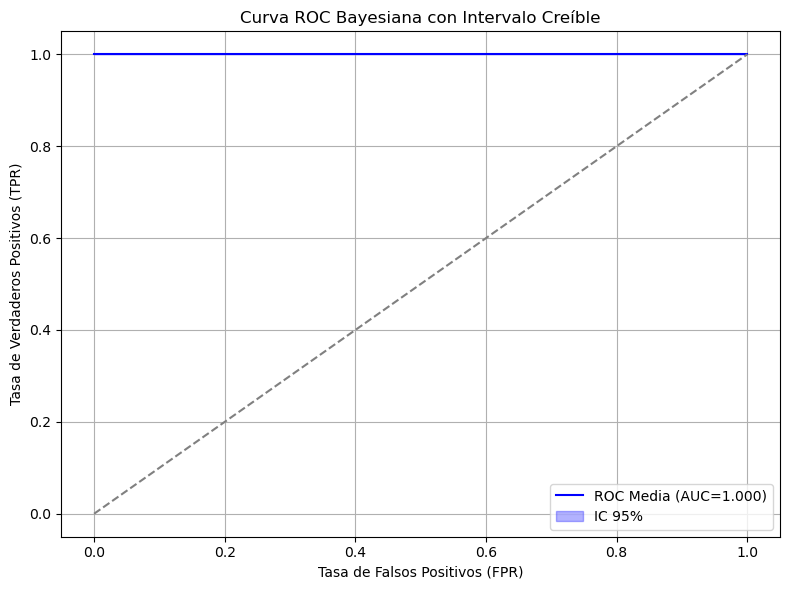

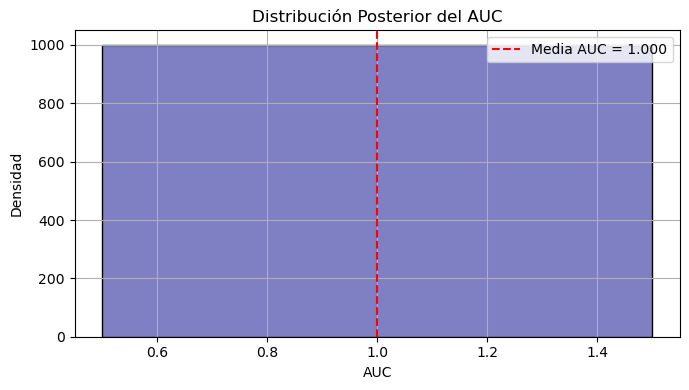

In [178]:
# --- Paso 1: Generar las probabilidades desde muestras del posterior ---
prob_matrices = posterior_connection_probs(samples_Z, samples_a)

# --- Paso 2: Obtener curvas ROC y AUC ---
fpr_list, tpr_list, auc_list = bayesian_roc_curves(Y_ML, prob_matrices)

# --- Paso 3: Visualizar resultados ---
plot_bayesian_roc(fpr_list, tpr_list, auc_list)
plot_auc_distribution(auc_list)


## References

[1] Hoff, P. D., Raftery, A. E., & Handcock, M. S. (2002). Latent space approaches to social network analysis. Journal of the American Statistical Association, 97(460), 1090-1098. https://doi.org/10.1198/016214502388618906